In [49]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

import tensorflow as tf
from tensorflow import keras

import os
import zipfile
import cv2


import warnings
warnings.filterwarnings("ignore")

import sys
print("Python Version: ", sys.version)
print("Tensorflow Version: ", tf.__version__)

# DEFINED
BATCH_SIZE = 32
IMG_WIDTH  = 227
IMG_HEIGHT = 227

%matplotlib inline

Python Version:  3.10.13 | packaged by Anaconda, Inc. | (main, Sep 11 2023, 13:15:57) [MSC v.1916 64 bit (AMD64)]
Tensorflow Version:  2.10.0


In [50]:
# Load model
model = keras.models.load_model("../TrainingModels/AlexNet.h5")

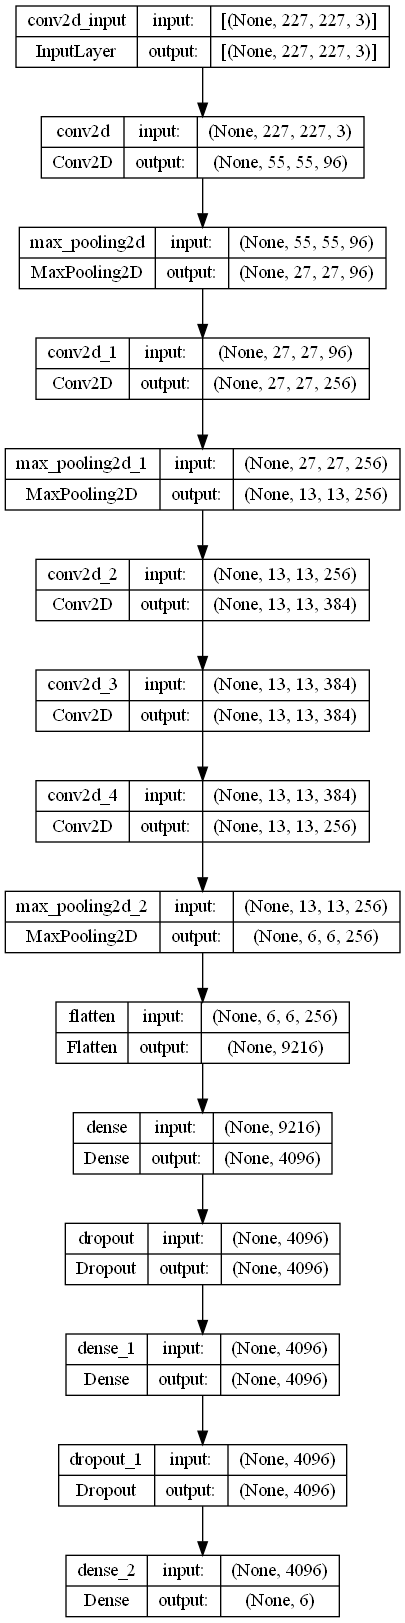

In [51]:
keras.utils.plot_model(model, show_shapes=True, show_layer_names=True)

In [52]:
# Set up for using GPU (don't recommend if your GPU efficiency is lower than CPU)
# Also if you use Google Colab, it's not necessary to use these code

physical_devices = tf.config.list_physical_devices('GPU')
if len(physical_devices) > 0:
    # Set only the first GPU device to be visible
    tf.config.experimental.set_visible_devices(physical_devices[0], 'GPU')
    print(f"Using only GPU device {physical_devices[0].name}\n")
else:
    print("No physical GPU devices found! \n")

# Verify GPU visibility in TensorFlow
if tf.config.list_physical_devices('GPU'):
    print("GPU is available")
else:
    print("GPU is not available")

No physical GPU devices found! 

GPU is not available


In [53]:
# unzip dataset file
path_to_zip_file = '../Furniture_Data.zip'
# with zipfile.ZipFile(path_to_zip_file, 'r') as zip_ref:
#     zip_ref.extractall('.')
#     zip_ref.close()

In [54]:
# Define the root directory where your categorical folders are located
base_data_dir = "../Furniture_Data"

# Function to get all folder names within a directory
def get_furiture_categories(directory):
    folders = []
    for item in os.listdir(directory):
        if os.path.isdir(os.path.join(directory, item)):
            folders.append(item)
    return folders

# Function to get the number of categorical folders and the number of folders within each categorical folder
def get_category_info(root_dir):
    categorical_folders = get_furiture_categories(root_dir)
    num_categorical_folders = len(categorical_folders)
    folder_info = {}
    for cat_folder in categorical_folders:
        cat_folder_path = os.path.join(root_dir, cat_folder)
        folders_in_cat = get_furiture_categories(cat_folder_path)
        num_folders_in_cat = len(folders_in_cat)
        folder_info[cat_folder] = {
            "num_folders": num_folders_in_cat,
            "folders": folders_in_cat
        }
    return num_categorical_folders, folder_info

In [55]:
# Get the number of categorical folders and the number of folders within each categorical folder
num_classes, folder_info = get_category_info(base_data_dir)
print("Number of categorical folders:", num_classes)
print("Folder info within each categorical folder:")
for cat_folder, info in folder_info.items():
    print(f" - {cat_folder}: {info['num_folders']} folders")
    print(f"   {info['folders']}")


Number of categorical folders: 6
Folder info within each categorical folder:
 - beds: 17 folders
   ['Asian', 'Beach', 'Contemporary', 'Craftsman', 'Eclectic', 'Farmhouse', 'Industrial', 'Mediterranean', 'Midcentury', 'Modern', 'Rustic', 'Scandinavian', 'Southwestern', 'Traditional', 'Transitional', 'Tropical', 'Victorian']
 - chairs: 17 folders
   ['Asian', 'Beach', 'Contemporary', 'Craftsman', 'Eclectic', 'Farmhouse', 'Industrial', 'Mediterranean', 'Midcentury', 'Modern', 'Rustic', 'Scandinavian', 'Southwestern', 'Traditional', 'Transitional', 'Tropical', 'Victorian']
 - dressers: 17 folders
   ['Asian', 'Beach', 'Contemporary', 'Craftsman', 'Eclectic', 'Farmhouse', 'Industrial', 'Mediterranean', 'Midcentury', 'Modern', 'Rustic', 'Scandinavian', 'Southwestern', 'Traditional', 'Transitional', 'Tropical', 'Victorian']
 - lamps: 17 folders
   ['Asian', 'Beach', 'Contemporary', 'Craftsman', 'Eclectic', 'Farmhouse', 'Industrial', 'Mediterranean', 'Midcentury', 'Modern', 'Rustic', 'Scandin

In [56]:
# Function to get the image paths as a dictionary
def get_image_paths_dict(root_dir):
    image_paths_dict = {}
    for cat_folder, info in folder_info.items():
        cat_image_paths = {}
        for fur_type in info['folders']:
            dir_link = os.path.join(base_data_dir, cat_folder, fur_type)
            image_paths = [os.path.join(dir_link, img_path) for img_path in os.listdir(dir_link)]
            cat_image_paths[fur_type] = image_paths
        image_paths_dict[cat_folder] = cat_image_paths
    return image_paths_dict

# Get the image paths as a dictionary
image_paths_dict = get_image_paths_dict(base_data_dir)

# Print example paths from the dictionary
for cat_folder, fur_types in image_paths_dict.items():
    for fur_type, paths in fur_types.items():
        print(f"Category: {cat_folder}, Fur type: {fur_type}")
        print("Example paths:")
        for path in paths[:3]:  # print first 3 paths for each fur type
            print(path)
        print("...")

Category: beds, Fur type: Asian
Example paths:
../Furniture_Data\beds\Asian\19726asian-daybeds.jpg
../Furniture_Data\beds\Asian\20027asian-canopy-beds.jpg
../Furniture_Data\beds\Asian\20109asian-panel-beds.jpg
...
Category: beds, Fur type: Beach
Example paths:
../Furniture_Data\beds\Beach\24547beach-style-nightstands-and-bedside-tables.jpg
../Furniture_Data\beds\Beach\2832beach-style-canopy-beds.jpg
../Furniture_Data\beds\Beach\3858beach-style-panel-beds.jpg
...
Category: beds, Fur type: Contemporary
Example paths:
../Furniture_Data\beds\Contemporary\1001contemporary-platform-beds.jpg
../Furniture_Data\beds\Contemporary\1002contemporary-bunk-beds.jpg
../Furniture_Data\beds\Contemporary\1003contemporary-adjustable-beds.jpg
...
Category: beds, Fur type: Craftsman
Example paths:
../Furniture_Data\beds\Craftsman\2638craftsman-panel-beds.jpg
../Furniture_Data\beds\Craftsman\2671craftsman-platform-beds.jpg
../Furniture_Data\beds\Craftsman\27972craftsman-daybeds.jpg
...
Category: beds, Fur ty

In [57]:
# Convert the dictionary of image paths into a DataFrame
df_list = []

for cat_folder, fur_types in image_paths_dict.items():
    for fur_type, paths in fur_types.items():
        for path in paths:
            df_list.append({
                "Furniture_Category": cat_folder,
                "Furniture_Type": fur_type,
                "Image_Path": path
            })

# Create DataFrame from the list of dictionaries and shuffle it
furniture_df = pd.DataFrame(df_list)
shuffled_furniture_df = furniture_df.sample(frac=1).reset_index(drop=True)

# Print the DataFrame
shuffled_furniture_df.head()

,Furniture_Category,Furniture_Type,Image_Path
0,lamps,Scandinavian,../Furniture_Data\lamps\Scandinavian\23369scan...
1,chairs,Traditional,../Furniture_Data\chairs\Traditional\5410tradi...
2,chairs,Contemporary,../Furniture_Data\chairs\Contemporary\3287cont...
3,tables,Victorian,../Furniture_Data\tables\Victorian\42997victor...
4,lamps,Traditional,../Furniture_Data\lamps\Traditional\13377tradi...


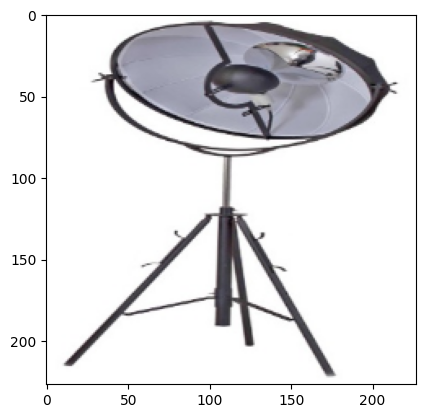

In [58]:
# Test dataset processing
def prepare(filepath):
    img_array = cv2.cvtColor(cv2.imread(filepath), cv2.COLOR_BGR2RGB)
    new_array = cv2.resize(img_array, (IMG_WIDTH, IMG_HEIGHT))
    return np.expand_dims(new_array, axis=0).repeat(BATCH_SIZE, axis=0)

img_test_list = []


# Add image for prediction testing before image processing
for i in range(25):
    first_data = shuffled_furniture_df.iloc[i]['Image_Path']
    # print(first_data)
    img_arr = prepare(first_data)
    img_test_list.append(img_arr)

# Check image after preprocess by using first image
plt.imshow(img_test_list[0][0])

Single Prediction in first data

In [59]:
categorical_folders = get_furiture_categories(base_data_dir)
categorical_folders

['beds', 'chairs', 'dressers', 'lamps', 'sofas', 'tables']

In [60]:
# Single predict
idx = 0
first_data = shuffled_furniture_df.iloc[idx]['Image_Path']
img_arr = prepare(first_data)

prediction = model.predict(img_arr)

predicted_class_index = np.argmax(prediction)

# Use the index to get the corresponding class label from categorical_folders
predicted_class_label = categorical_folders[predicted_class_index]

print('Predict: ' + predicted_class_label)
print('Actual: ' + shuffled_furniture_df.iloc[idx]['Furniture_Category'])


1/1 [==============================] - 0s 469ms/step
Predict: lamps
Actual: lamps


1/1 [==============================] - 0s 357ms/step


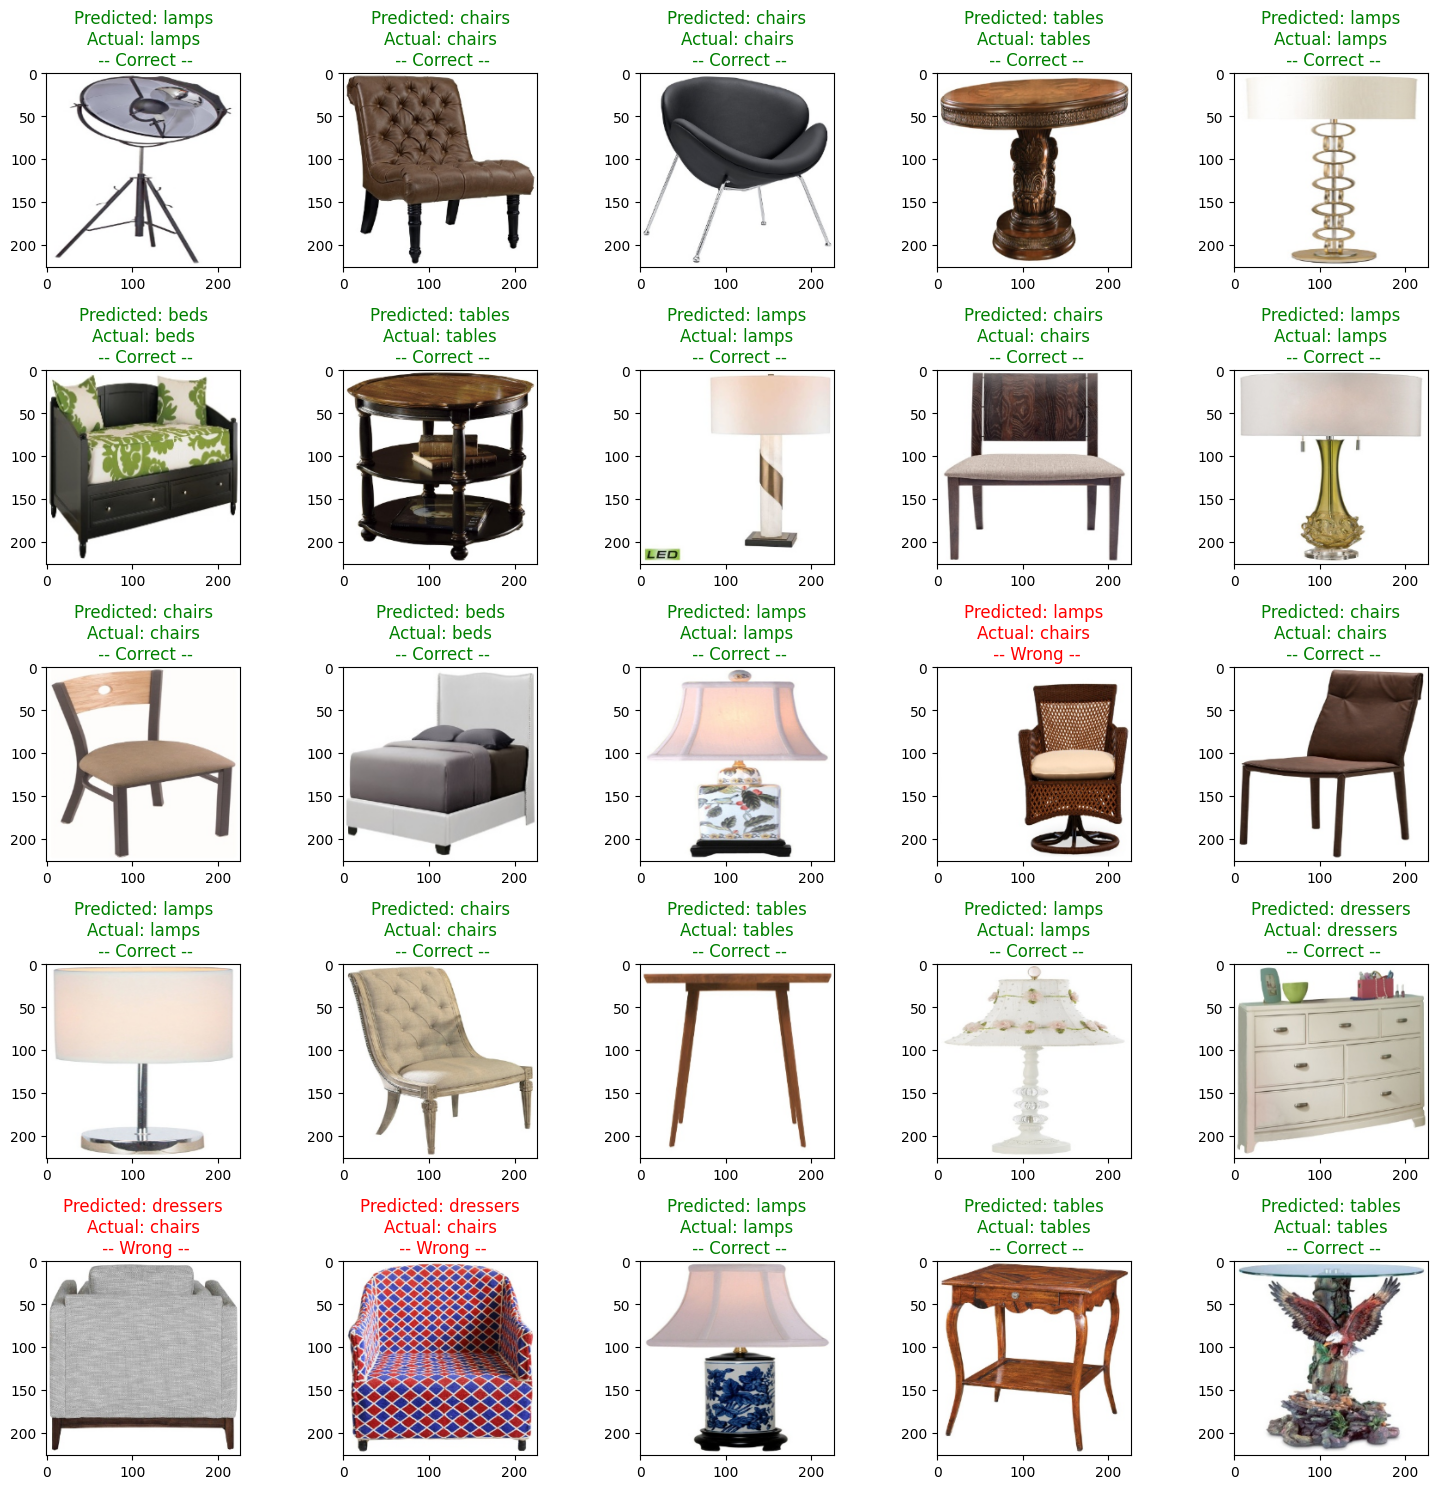

In [63]:
#  Multiple prediction using image table
fig, axes = plt.subplots(nrows=5, ncols=5, figsize=(15, 15))

predicted_result = []
for i in range(25):
    prediction = model.predict(img_test_list[i])
    predicted_class_index = np.argmax(prediction)

    # Use the index to get the corresponding class label from categorical_folders
    predicted_class_label = categorical_folders[predicted_class_index]

    predicted_result.append(predicted_class_label)

for i, ax in enumerate(axes.flat):
    ax.imshow(img_test_list[i][0])

    color = 'white'
    if predicted_result[i] == shuffled_furniture_df.loc[i, 'Furniture_Category']:
        color = 'green'
    else:
        color = 'red'

    def correct_wrong_predicted(item01, item02):

        if item01 == item02:
            return "Correct"
        else:
            return "Wrong"
        
        

    ax.set_title('Predicted: {}'.format(predicted_result[i]) +  
                 '\nActual: ' + shuffled_furniture_df.loc[i, 'Furniture_Category'] + 
                 '\n -- {} --'.format(correct_wrong_predicted(predicted_result[i], shuffled_furniture_df.loc[i, 'Furniture_Category'])), color=color )
plt.tight_layout()
plt.show()